In [1]:
import os
import sys

sys.path.append(os.path.abspath("../"))

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib.widgets import Slider

import numpy as np
import sympy as sym

import trical
from trical import classes
from trical.misc.constants import convert_m_a

In [2]:
sym.init_printing(forecolor="White")

# Single Species Trapped Ions System


In [3]:
# Number of Ions
N = 5

# Mass of Ytterbium 171 ion
m_1 = convert_m_a(171)

# Trapping strengths of conventional trap
omega_x = 2 * np.pi * 4e5
omega_y = 2 * np.pi * 3.6e5
omega_z = 2 * np.pi * 8e4
omega = np.array([omega_x, omega_y, omega_z])

# Polynomial coefficients for convential trap potential
alpha = np.zeros([3, 3, 3])
alpha[tuple(np.eye(3, dtype=int) * 2)] = m_1 * omega ** 2 / 2

# Conventional trap potential
p0 = classes.PolynomialPotential(alpha)

# Single species trapped ion system
ti0 = classes.TrappedIons(N, p0, m=m_1)

# Calculate equilibrium position and normal modes
ti0.principle_axis()
x_ep0 = ti0.x_ep
w0, b0 = ti0.w_pa, ti0.b_pa
b0 = np.array([b0[i * N : (i + 1) * N, i * N : (i + 1) * N] for i in range(3)])

# Multispecies Trapped Ions System
## Excluding Additonal Optical Potential

In [4]:
# Mass of Barium 133 ion
m_2 = convert_m_a(133)

# Define sympy symbols 
x = np.array(sym.symbols(" ".join(["x{}".format(i) for i in range(N)])))
y = np.array(sym.symbols(" ".join(["y{}".format(i) for i in range(N)])))
z = np.array(sym.symbols(" ".join(["z{}".format(i) for i in range(N)])))

# Arrangement of the ions
m = np.array([m_2, m_2, m_1, m_2, m_2])

# Conventional trap potential for multispecies system
expr = (
    (m_1 ** 2 * omega_x ** 2 * x ** 2 / (2 * m)).sum()
    + (m_1 ** 2 * omega_y ** 2 * y ** 2 / (2 * m)).sum()
    + (m_1 * omega_z ** 2 * z ** 2 / 2).sum()
)
p1 = trical.classes.AdvancedSymbolicPotential(N, expr)

# Multispecies trapped ion system w/o additional optical potential
ti1 = trical.classes.TrappedIons(N, p1, m=m)

# Calculate equilibrium position and normal modes
ti1.principle_axis()
w1, b1 = ti1.w_pa, ti1.b_pa
b1 = np.array([b1[i * N : (i + 1) * N, i * N : (i + 1) * N] for i in range(3)])

## Including Additional Optical Potential

In [5]:
# Optical potentials
p2 = [
    classes.GaussianOpticalPotential(
        ti1.x_ep[i],
        210e-3,
        375e-9,
        1e-6,
    )
    for i in (m == m_1).nonzero()[0]
]

# Multispecies trapped ion system w/ additional optical potential
ti2 = trical.classes.TrappedIons(N, p1, *p2, m=m)

# Calculate equilibrium position and normal modes
ti2.principle_axis()
w2, b2 = ti2.w_pa, ti2.b_pa
b2 = np.array([b2[i * N : (i + 1) * N, i * N : (i + 1) * N] for i in range(3)])

# Plots
## Equilibrium Position

In [6]:
%matplotlib inline
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True

Text(0, 0.5, '$x \\ (\\mathrm{\\mu m})$')

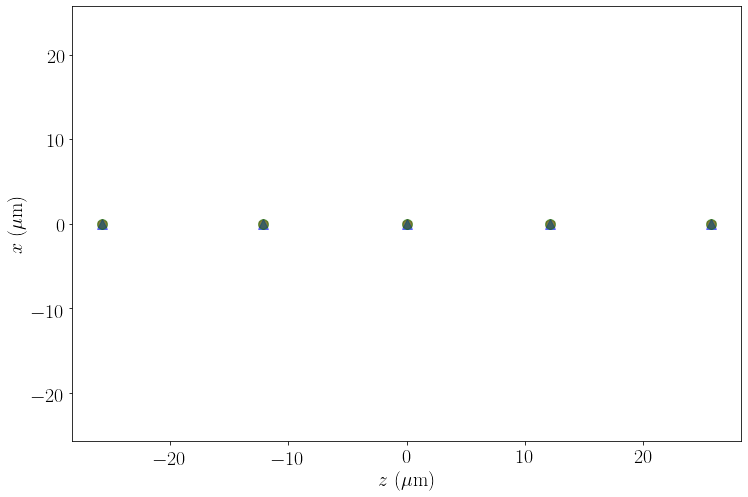

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

x_ep = np.array([ti0.x_ep, ti1.x_ep, ti2.x_ep]) / 1e-6

for i in range(3):
    ax.plot(
        x_ep[i, :, 2],
        x_ep[i, :, 0],
        ["h", "^", "o"][i],
        color=["r", "b", "g"][i],
        alpha=0.5,
        ms=10,
    )

ax.set_xlim(
    1.05 * x_ep.min() - 0.05 * x_ep.max(), -0.05 * x_ep.min() + 1.05 * x_ep.max()
)
ax.set_xlabel(r"$z \ (\mathrm{\mu m})$")
ax.set_ylim(x_ep.min(), x_ep.max())
ax.set_ylabel(r"$x \ (\mathrm{\mu m})$")

## Normal Modes

In [8]:
%matplotlib qt5
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True

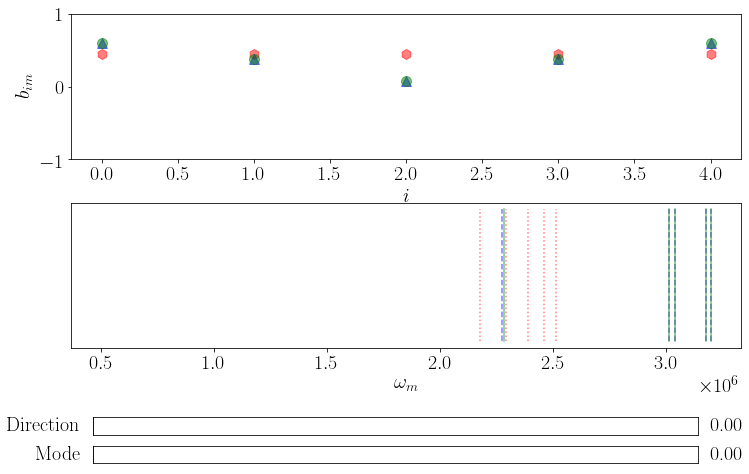

In [9]:
fig = plt.figure()
ax = fig.subplots(2, 1)
fig.subplots_adjust(bottom=0.3, hspace=0.3)

(l0,) = ax[0].plot(range(N), b0[0, :, 0], "h", color="r", alpha=0.5, ms=10)
(l1,) = ax[0].plot(range(N), b1[0, :, 0], "^", color="b", alpha=0.5, ms=10)
(l2,) = ax[0].plot(range(N), b2[0, :, 0], "o", color="g", alpha=0.5, ms=10)

l3 = [
    ax[1].plot([w0[i], w0[i]], [0, 1], ":", color="r", alpha=0.5)[0] for i in range(N)
]
l4 = [
    ax[1].plot([w1[i], w1[i]], [0, 1], "--", color="b", alpha=0.5)[0] for i in range(N)
]
l5 = [
    ax[1].plot([w2[i], w2[i]], [0, 1], "-", color="g", alpha=0.5)[0] for i in range(N)
]

w_min = np.min([w0.min(), w1.min(), w2.min()])
w_max = np.max([w0.max(), w1.max(), w2.max()])

ax[0].set_ylim(-1, 1)
ax[0].set_xlabel(r"$i$")
ax[0].set_ylabel(r"$b_{im}$")

ax[1].set_xlim(w_min - 0.05 * (w_max - w_min), w_max + 0.05 * (w_max - w_min))
ax[1].set_xlabel(r"$\omega_m$")
ax[1].set_yticks([])


[ax[i].ticklabel_format(style="sci", scilimits=(-1, 1)) for i in range(2)]


def update(val):
    s0 = np.sign(b0[int(slider_direction.val), :, int(slider_mode.val)][0])
    s1 = np.sign(b1[int(slider_direction.val), :, int(slider_mode.val)][0])
    s2 = np.sign(b2[int(slider_direction.val), :, int(slider_mode.val)][0])
    l0.set_ydata(b0[int(slider_direction.val), :, int(slider_mode.val)])
    l1.set_ydata(
        b1[int(slider_direction.val), :, int(slider_mode.val)]
        if s0 == s1
        else -b1[int(slider_direction.val), :, int(slider_mode.val)]
    )
    l2.set_ydata(
        b2[int(slider_direction.val), :, int(slider_mode.val)]
        if s0 == s2
        else -b2[int(slider_direction.val), :, int(slider_mode.val)]
    )

    [
        l3[i].set_xdata(
            [
                w0[N * int(slider_direction.val) + i],
                w0[N * int(slider_direction.val) + i],
            ]
        )
        for i in range(N)
    ]
    [
        l4[i].set_xdata(
            [
                w1[N * int(slider_direction.val) + i],
                w1[N * int(slider_direction.val) + i],
            ]
        )
        for i in range(N)
    ]
    [
        l5[i].set_xdata(
            [
                w2[N * int(slider_direction.val) + i],
                w2[N * int(slider_direction.val) + i],
            ]
        )
        for i in range(N)
    ]
    fig.canvas.draw_idle()


ax_direction = plt.axes([0.15, 0.15, 0.7, 0.03])
slider_direction = Slider(ax_direction, r"Direction", 0, 2, valinit=0, valstep=1)
slider_direction.on_changed(update)

ax_mode = plt.axes([0.15, 0.10, 0.7, 0.03])
slider_mode = Slider(ax_mode, r"Mode", 0, N - 1, valinit=0, valstep=1)
slider_mode.on_changed(update)

# SimulatedSpinLattice

In [10]:
%matplotlib inline
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True

## Single Species

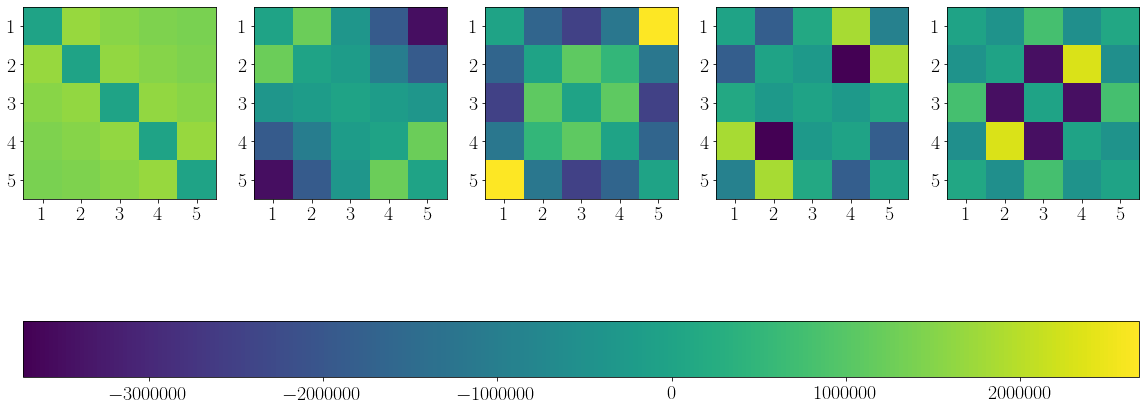

In [11]:
wavelength = 355e-9

detuning = 2 * np.pi * 1e3
mu = np.array([np.array([w0[N + i] + detuning]) for i in range(N)])
Omega = np.full((N, 1), 1e6)

ssl = [
    classes.SimulatedSpinLattice(ti0, mu[i], Omega, k=2 * np.pi / wavelength, direc="y")
    for i in range(N)
]

J = np.array([ssl[i].J for i in range(N)])

norm = matplotlib.colors.Normalize(J.min(), J.max())
sm = cm.ScalarMappable(norm, cmap=cm.viridis)
sm.set_array(J)

fig = plt.figure(figsize=(20, 15))
ax = [fig.add_subplot(1, N, i + 1) for i in range(N)]
for i in range(N):
    im = ax[i].imshow(J[i], cmap=cm.viridis, norm=norm)
    ax[i].set_xticks(np.arange(N))
    ax[i].set_yticks(np.arange(N))
    ax[i].set_xticklabels(np.arange(N) + 1)
    ax[i].set_yticklabels(np.arange(N) + 1)
fig.colorbar(sm, ax=ax, orientation="horizontal")

## Multispecies w/o Optical Potential

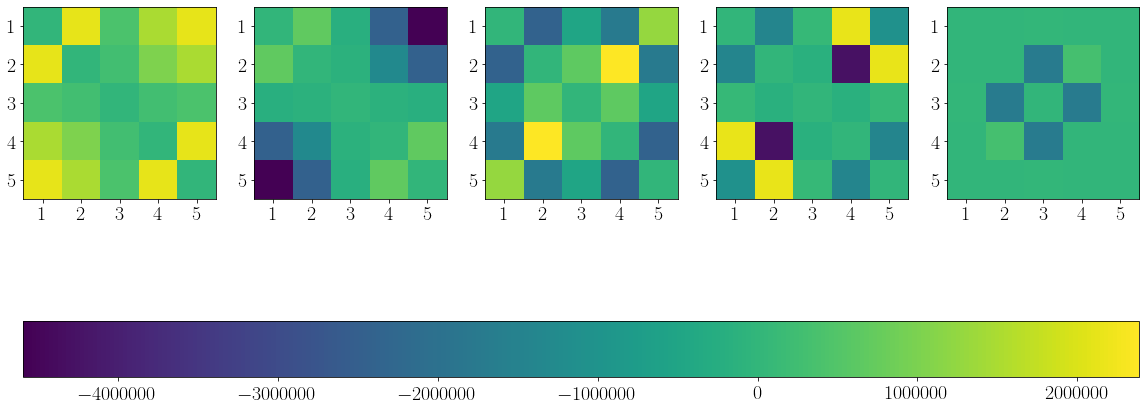

In [12]:
wavelength = 355e-9

detuning = 2 * np.pi * 1e3
mu = np.array([np.array([w1[N + i] + detuning]) for i in range(N)])
omega = np.full((N, 1), 1e6)

ssl = [
    classes.SimulatedSpinLattice(ti1, mu[i], omega, k=2 * np.pi / wavelength, direc="y")
    for i in range(N)
]

J = np.array([ssl[i].J for i in range(N)])

norm = matplotlib.colors.Normalize(J.min(), J.max())
sm = cm.ScalarMappable(norm, cmap=cm.viridis)
sm.set_array(J)

fig = plt.figure(figsize=(20, 15))
ax = [fig.add_subplot(1, N, i + 1) for i in range(N)]
for i in range(N):
    im = ax[i].imshow(J[i], cmap=cm.viridis, norm=norm)
    ax[i].set_xticks(np.arange(N))
    ax[i].set_yticks(np.arange(N))
    ax[i].set_xticklabels(np.arange(N) + 1)
    ax[i].set_yticklabels(np.arange(N) + 1)
fig.colorbar(sm, ax=ax,orientation="horizontal")

## Multispecies w/ Optical Potential

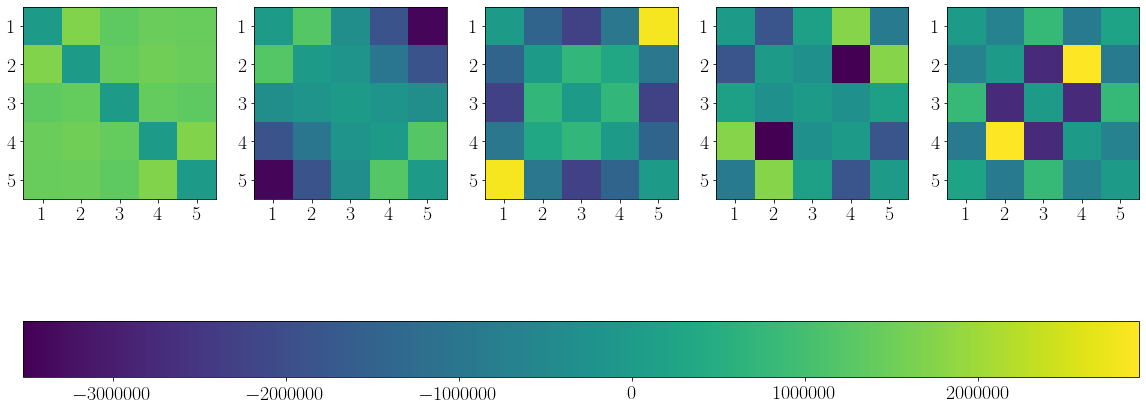

In [13]:
wavelength = 355e-9

detuning = 2 * np.pi * 1e3
mu = np.array([np.array([w2[N + i] + detuning]) for i in range(N)])
omega = np.full((N, 1), 1e6)

ssl = [
    classes.SimulatedSpinLattice(ti2, mu[i], omega, k=2 * np.pi / wavelength, direc="y")
    for i in range(N)
]

J = np.array([ssl[i].J for i in range(N)])

norm = matplotlib.colors.Normalize(J.min(), J.max())
sm = cm.ScalarMappable(norm, cmap=cm.viridis)
sm.set_array(J)

fig = plt.figure(figsize=(20, 15))
ax = [fig.add_subplot(1, N, i + 1) for i in range(N)]
for i in range(N):
    im = ax[i].imshow(J[i], cmap=cm.viridis, norm=norm)
    ax[i].set_xticks(np.arange(N))
    ax[i].set_yticks(np.arange(N))
    ax[i].set_xticklabels(np.arange(N) + 1)
    ax[i].set_yticklabels(np.arange(N) + 1)
fig.colorbar(sm, ax=ax,orientation="horizontal")